In [1]:
import numpy as np

In [2]:
m=30
n=100
sigma=0.1

S = np.random.rand(m,1)
#S = np.ones((m,1))
A = np.random.rand(m,m)
A, _ = np.linalg.qr(A) #ortogonalna da nam norme vektora ne eksplodiraju

for i in range(n):
    S = np.hstack((S, A@(S[:,-1].reshape(-1,1))))

S_bez_suma = S
S = S+np.random.normal(0, sigma, S.shape)
##na par mjesta veliki noise
ind1 = np.random.choice(m, 300)
ind2 = np.random.choice(n+1, 300)
S[ind1, ind2]=0.0
###eksp
#S = S+np.random.standard_exponential(S.shape)/5
#S = S+np.random.standard_exponential(S.shape)/100

X = S[:, :-1]
Y = S[:, 1:]

In [3]:
def stln_dmd_v3(Xt, Yt, tol=1e-12, max_iter=5000, w=1000):
    (n,m) = Xt.shape
    alpha = np.zeros((n*m, 1))
    beta = np.zeros((m,1))

    At = np.linalg.pinv(Xt)@Yt
    r0 = Yt - Xt@At
    print(r0)
    r0 = r0.reshape(-1,1, order='F')
    print(r0)


    """beta = r0[-m:, :]
    br=0
    for i in range((n-1)*m):
        if(br%n == 0):
            br+=1
        alpha[br,0] = r0[i,0]
    """
    indeksi=[]
    for i in range(m*n):
        if(i%n != 0):
            indeksi += [i]
    
    
    E = np.zeros_like(Xt)

    P_ind = np.zeros((m*n, m*n))
    br=0
    for i in range(P_ind.shape[1]-m):
        if(br%n==0):
            br=br+1
        P_ind[i, br] = -1.0
        br=br+1

    At_norm = 1
    alpha_norm = 1
    beta_norm = 1

    M1 = np.kron(np.eye(m), Xt+E)
    #M2 = np.kron(At, np.eye(n))+P_ind
    M2 = np.kron(At.T, np.eye(n))+P_ind
    M3 = np.vstack((np.zeros(((n-1)*m, m)), np.eye(m)))

    M = np.hstack((M1, M2, -M3))

    D1 = np.eye(n*m)
    D1[indeksi,indeksi] = 2.0
    D1 = np.hstack((np.zeros((n*m,m*m)), D1, np.zeros((n*m, m))))
    D2 = np.hstack((np.zeros((m, m*(m+n))), np.eye(m)))

    M = np.vstack((w*M,D1,D2))

    alpha_poc = alpha
    beta_poc = beta
    At_poc = At.reshape(-1,1, order='F')
    print(np.linalg.norm(r0))

    rhs = np.vstack((w*r0, alpha, beta)) 

    iter=0

    while((At_norm > tol or alpha_norm > tol or beta_norm > tol) and iter<max_iter):
        sol,_,_,_ = np.linalg.lstsq(M, rhs)

        At = sol[:m*m,:]
        alpha = sol[m*m:m*(m+n),:]
        beta = sol[-m:,:]

        At_poc += At
        alpha_poc += alpha
        beta_poc += beta

        At_norm = np.linalg.norm(At)
        alpha_norm = np.linalg.norm(alpha)
        beta_norm = np.linalg.norm(beta)

        At_norm = np.linalg.norm(At)/np.linalg.norm(At_poc)
        alpha_norm = np.linalg.norm(alpha)/np.linalg.norm(alpha_poc)
        beta_norm = np.linalg.norm(beta)/np.linalg.norm(beta_poc)

        print(At_norm, alpha_norm, beta_norm)

        #r0 = r0 -np.kron(np.eye(m),(Xt+alpha_poc.reshape(n,m, order='F')))@At - np.kron(At_poc.reshape(m,m, order='F'), np.eye(n))@alpha -P_ind@alpha + M3 @ beta
        r0 = r0 -np.kron(np.eye(m),(Xt+alpha_poc.reshape(n,m, order='F')))@At - np.kron(At_poc.reshape(m,m), np.eye(n))@alpha -P_ind@alpha + M3 @ beta

        print("r0:",np.linalg.norm(r0))

        #provjeri..
        E = alpha_poc.reshape(n,m, order='F') 
        M1 = np.kron(np.eye(m), Xt+E)
        #M2 = np.kron(At_poc.reshape(m,m, order='F').T, np.eye(n))+P_ind
        M2 = np.kron(At_poc.reshape(m,m), np.eye(n))+P_ind #At_poc.reshape(m,m) isto kao (At_poc.T).reshape(m,m, order='F') 
        M = np.hstack((M1, M2, -M3))
        M= np.vstack((w*M,D1,D2))


        rhs = np.vstack((w*r0, -alpha_poc, -beta_poc)) ##ili bez poc?

        iter+=1

    Ey = np.vstack(((-P_ind[:-m,:]@alpha_poc[:,0]).reshape(n-1,m, order='F'), beta_poc.reshape(1,-1, order='F')))
    print(beta_poc.reshape(1,-1, order='F'))
    print("broj iteracija:",iter)

    return At_poc.reshape(m,m), alpha_poc.reshape(m,n), Ey.T


In [4]:
def tls_classical(Xt, Yt):
    (m,n)=X.shape
    C = np.hstack((Xt, Yt))
    #print(C.shape)
    U_c, S_c, V_c = np.linalg.svd(C, full_matrices=False)
    #print(U_c.shape, S_c.shape, V_c.shape)
    V_c = np.conj(V_c.T)
    #print("m={}, U shape = {}, V shape = {}".format(m, U_c.shape, V_c.shape))
    #print(S_c)

    Ex = -(U_c[:, m:]*S_c[m:])
    Ey = Ex@(V_c[m:,m:].T)
    Ex = Ex@(V_c[:m, m:].T)

    A = np.linalg.solve((V_c[m:,m:]).T,-V_c[:m,m:].T)

    return A, Ex.T, Ey.T

In [5]:
A_class, Ex_class, Ey_class = tls_classical(X.T, Y.T)
A_class

array([[-3.30477506e-01, -3.10982317e-01,  4.66732151e-01,
        -8.11860522e-02, -1.09022575e-01,  2.86321723e-01,
         2.70803612e-02, -2.20955125e-01,  2.23604996e-01,
         9.78600764e-02,  7.68908892e-02, -2.47875881e-01,
        -4.17892489e-01, -4.74303694e-02,  3.52120983e-02,
         2.82452394e-02,  1.17835137e-01, -2.29280399e-01,
        -1.38539367e-02,  3.16876615e-01, -3.17506024e-01,
         1.71332493e-01, -6.53894226e-01, -2.70991566e-02,
        -1.00100617e-01,  2.78989271e-01,  7.36396118e-01,
        -2.45467774e-01,  2.39104802e-01,  2.92791587e-01],
       [-3.22540208e-01, -3.70961947e-01, -3.38244069e-02,
        -6.63185259e-02, -2.72896609e-02,  2.13341616e-01,
        -3.33576951e-02, -5.05839644e-02, -8.41824474e-02,
         8.79812236e-02, -1.50058857e-01, -1.57179709e-01,
        -9.19345602e-02, -9.30485769e-02, -3.33684736e-01,
        -2.79474020e-02,  2.05753183e-01,  3.52818988e-01,
        -2.89519541e-01, -6.97065937e-03,  9.42143380e-

In [6]:
A_rek, Ex, Ey = stln_dmd_v3(X.T, Y.T, w=1, tol=1e-2, max_iter=10)

[[ 0.31729275 -0.07288489  0.20769776 ...  0.16917148  0.02311565
  -0.14614722]
 [-0.19318998 -0.20949388  0.20133081 ... -0.16501542  0.0384639
  -0.14240274]
 [-0.31567798 -0.03409054 -0.24554685 ...  0.15069425 -0.0124762
  -0.3207611 ]
 ...
 [ 0.03426215 -0.2750358  -0.116053   ... -0.33404765  0.38088802
   0.35131568]
 [ 0.06359686 -0.17447877 -0.30281401 ... -0.16286098 -0.47512562
  -0.02129696]
 [ 0.21219476 -0.15846115 -0.25701499 ... -0.40617987 -0.44968627
  -0.30384873]]
[[ 0.31729275]
 [-0.19318998]
 [-0.31567798]
 ...
 [ 0.35131568]
 [-0.02129696]
 [-0.30384873]]
13.223357423017323
0.07892169529907261 1.0 1.0
r0: 9.595448560114713
0.08237252290762022 0.25427546021922987 0.15689283024262576
r0: 8.43755063731611
0.03619194159279874 0.10015270966674081 0.054307140114059016
r0: 8.020243380447537
0.02628034698619689 0.05038392888641826 0.028441634082010933
r0: 7.853465434693191
0.01811871679381512 0.031337894229059284 0.016650182363873493
r0: 7.777256186035282
0.013603930919

In [7]:
print(np.linalg.norm(A_class-A), np.linalg.norm(A_rek-A))
print(np.linalg.norm(A_class@X-Y))
print(np.linalg.norm(A_rek@(X)-Y))

3.9346905863325805 3.064142977442538
15.093653142014047
13.664129711544895


In [ ]:
#np.save("TLS-bez_suma-norm-i-par-0-v5", S_bez_suma)
#np.save("TLS-sum-norm-i-par-0-v5", S)

#veliki n - jako sporo :(

[ 0.00286927  0.36261237 -0.1198897   0.03547276 -0.25603076 -0.2182636
  0.01156528 -0.12598288 -0.16669554  0.26250669 -0.05383385 -0.14904569
  0.20251356  0.2229685   0.17193241 -0.15697864 -0.00712739  0.28001599
  0.27717212 -0.30559146 -0.27989614  0.0181951   0.1769834   0.18205268
  0.06249154  0.14559786  0.12185624 -0.01333175  0.14940093 -0.05172661]
[ 0.12618689  0.24950318 -0.11923455  0.13706023 -0.21670227 -0.28143809
 -0.1270099  -0.11006263 -0.14532246  0.28591904 -0.09331401 -0.1675932
  0.08245255  0.30283835  0.04917315 -0.27989008  0.01899187  0.19726508
  0.24359148 -0.3220347  -0.35857703  0.05792285  0.11396203  0.16684156
  0.18146832  0.19386978  0.10802607 -0.1816493   0.01124495  0.01946653]
[ 0.28632172  0.21334162 -0.1708739   0.1603904  -0.19479616 -0.32345494
 -0.07907519 -0.15918429 -0.14575343  0.39875097 -0.05110838 -0.15609179
  0.12705343  0.35534279 -0.09020138 -0.48760386  0.07699576  0.18933831
  0.27623777 -0.29945248 -0.37733364  0.04927543  0

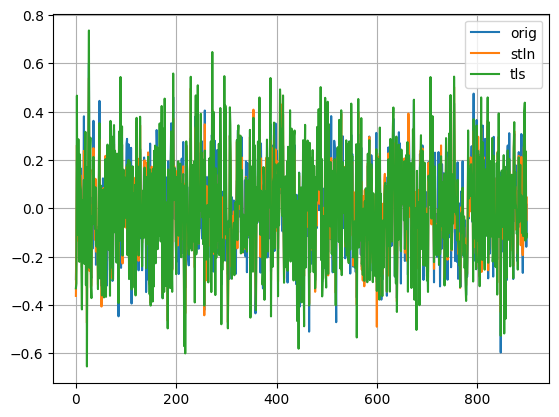

In [12]:
import matplotlib.pyplot as plt
koji=5
print(A[:, koji])
print(A_rek[:, koji])
print(A_class[:, koji])

plt.plot(range(A.shape[0]**2),A.flatten(), label="orig")
plt.plot(range(A.shape[0]**2),A_rek.flatten(), label="stln")
plt.plot(range(A.shape[0]**2),A_class.flatten(), label="tls")
plt.grid()
plt.legend()

Text(0.5, 1.0, 'TLS')

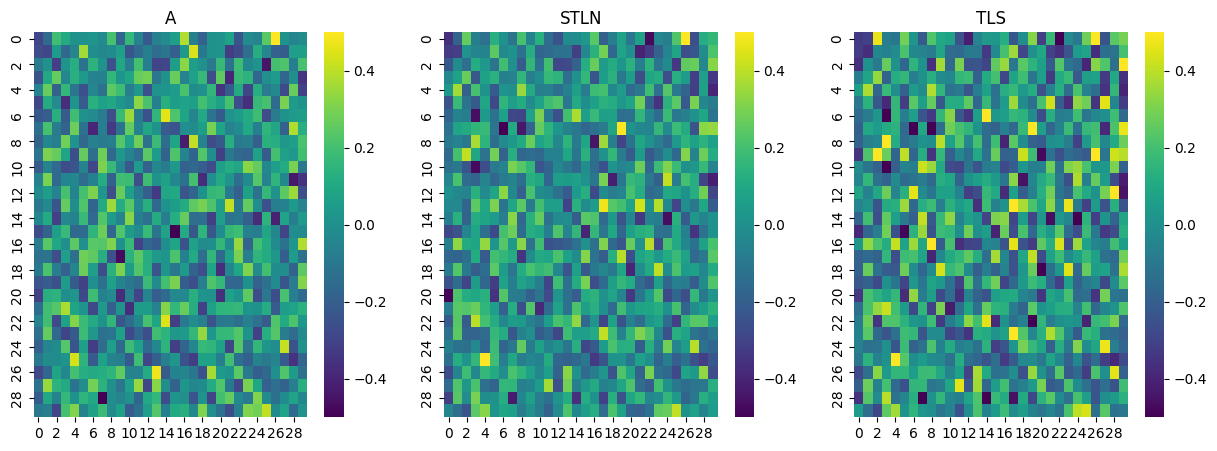

In [16]:
import seaborn as sns

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(A,  ax=ax1, cmap='viridis'
            , vmin=-0.5
            , vmax=0.5)
ax1.set_title('A')


sns.heatmap(A_rek, ax=ax2, cmap='viridis'
            , vmin=-0.5
            , vmax=0.5)
ax2.set_title('STLN')

sns.heatmap(A_class, ax=ax3, cmap='viridis'
            , vmin=-0.5
            , vmax=0.5)
ax3.set_title('TLS')



Text(0.5, 1.0, 'TLS')

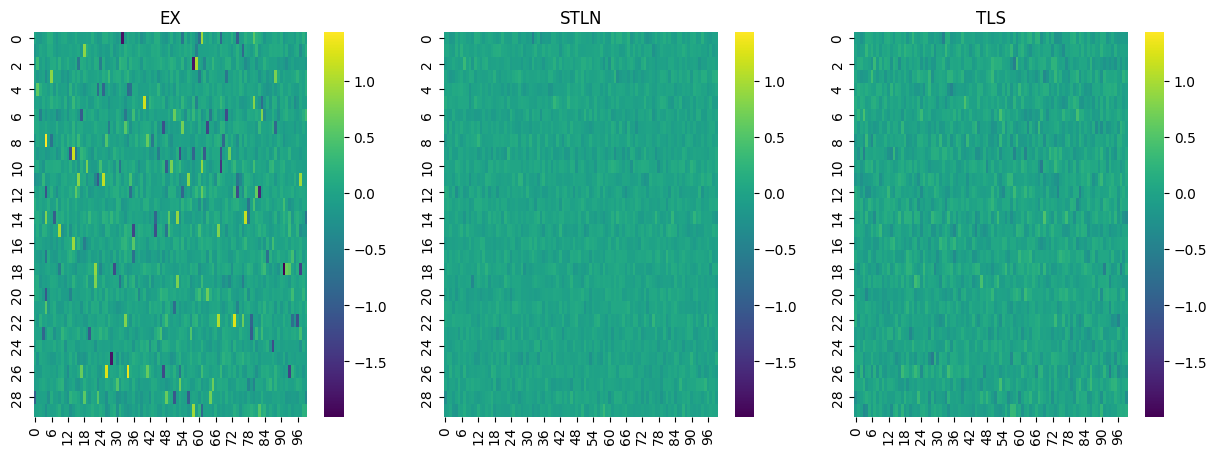

In [10]:
import seaborn as sns

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

vminn = np.min((S-S_bez_suma)[:,:-1])
vmaxx = np.max((S-S_bez_suma)[:,:-1])


sns.heatmap((S-S_bez_suma)[:,:-1],  ax=ax1, cmap='viridis'
            , vmin=vminn
            , vmax=vmaxx
            )
ax1.set_title('EX')


sns.heatmap(-Ex, ax=ax2, cmap='viridis'
            , vmin=vminn
            , vmax=vmaxx
            )
ax2.set_title('STLN')

sns.heatmap(-Ex_class, ax=ax3, cmap='viridis'
            , vmin=vminn
            , vmax=vmaxx
            )
ax3.set_title('TLS')



In [257]:
koji=2

print((S-S_bez_suma)[:,koji])
print(Ex[:, koji])
print(Ex_class[:,koji])

[ 0.01138438  0.13494708  0.0776886  -0.15258364 -0.05032325  0.11923697
 -0.01573605 -0.1961551  -0.18549891  0.10454014]
[-0.02487388 -0.01067635 -0.00124595 -0.00512934  0.03673928  0.00193071
 -0.01614536  0.02702562  0.02792344 -0.03985087]
[ 0.00327226  0.05228858  0.03697648  0.04856809 -0.00491815 -0.0532553
  0.04696158  0.09991783  0.12569834 -0.01832763]


In [247]:
koji = 3
print(S_bez_suma[:,koji])
print((X-Ex)[:,koji])
print((X-Ex_class)[:, koji])

print("Y")
koji = 2
print(S_bez_suma[:,koji+1])
print((Y-Ey)[:,koji])
print((Y-Ey_class)[:, koji])

[-1.02785896 -0.88928662  0.8153937   0.07852655 -0.16747295]
[-0.9732256  -0.94185303  0.6849629   0.14213336 -0.19331176]
[-0.96624709 -0.92288584  0.6997807   0.13562963 -0.19807197]
Y
[-1.02785896 -0.88928662  0.8153937   0.07852655 -0.16747295]
[-0.9732256  -0.94185303  0.6849629   0.14213336 -0.19331176]
[-0.95368722 -0.94482849  0.78215372  0.13522426 -0.1792454 ]


In [197]:
Y - A_rek@(X)

array([[ 0.0093388 , -0.01923974,  0.00912145, -0.01808385, -0.01426093,
         0.00485562, -0.01140119, -0.01688823, -0.02859543, -0.01803302,
        -0.01911574,  0.00102093,  0.00248478, -0.01515298,  0.02489637,
        -0.00932065,  0.01034447, -0.02258083,  0.00377302,  0.01695002],
       [ 0.02505332, -0.01023297, -0.0148573 , -0.01101886, -0.04142916,
        -0.01549293,  0.00400819,  0.02496916, -0.01839077, -0.02040219,
        -0.00988232,  0.00588483, -0.00346451, -0.02348271, -0.01653262,
         0.00163504,  0.01076555,  0.00275014,  0.0126887 , -0.00709755],
       [ 0.02654943, -0.00605763,  0.01711177,  0.03003872,  0.008438  ,
         0.03346383,  0.01562991,  0.00058566,  0.00162323,  0.00874355,
        -0.01579158, -0.04065533,  0.00993346, -0.00857089, -0.00011123,
         0.0240427 ,  0.01017783,  0.00472408, -0.00174805, -0.01651605],
       [-0.02202436, -0.0215826 ,  0.00488334, -0.00778877, -0.01428021,
         0.01752529,  0.05278609,  0.01054141, -

In [198]:
Ex[:, 1:]


array([[-0.00415036,  0.0056177 ,  0.00742555, -0.00118695,  0.01346411,
        -0.0069227 , -0.00847594,  0.01522798,  0.00062808,  0.01669787,
         0.01944288, -0.00426716, -0.01538385,  0.02095374, -0.00461035,
        -0.00262996, -0.00227756,  0.00147411, -0.01820593],
       [-0.0307628 ,  0.01302169,  0.01767254,  0.00385146,  0.02574372,
         0.02497395, -0.01305799, -0.01259496, -0.00907772,  0.01441795,
         0.02448951, -0.00760294, -0.00267885,  0.00593944,  0.03102945,
         0.00357121,  0.00285178,  0.01010585, -0.01446576],
       [-0.01139072,  0.02166885, -0.01466246, -0.00093717, -0.00062197,
        -0.02159285, -0.00218819, -0.02345812, -0.00116445, -0.00406741,
        -0.00960605, -0.01394502,  0.00138969,  0.01855009, -0.01311111,
         0.00853747, -0.01571212, -0.01037487, -0.00979189],
       [ 0.01371755,  0.01393593,  0.03183518, -0.0100804 , -0.00804026,
        -0.00872674,  0.00615175,  0.02082203,  0.00286958, -0.02651123,
        -0.021

In [199]:
Ey

array([[-0.00415036,  0.0056177 ,  0.00742555, -0.00118695,  0.01346411,
        -0.0069227 , -0.00847594,  0.01522798,  0.00062808,  0.01669787,
         0.01944288, -0.00426716, -0.01538385,  0.02095374, -0.00461035,
        -0.00262996, -0.00227756,  0.00147411, -0.01820593,  0.01331306],
       [-0.0307628 ,  0.01302169,  0.01767254,  0.00385146,  0.02574372,
         0.02497395, -0.01305799, -0.01259496, -0.00907772,  0.01441795,
         0.02448951, -0.00760294, -0.00267885,  0.00593944,  0.03102945,
         0.00357121,  0.00285178,  0.01010585, -0.01446576, -0.01814502],
       [-0.01139072,  0.02166885, -0.01466246, -0.00093717, -0.00062197,
        -0.02159285, -0.00218819, -0.02345812, -0.00116445, -0.00406741,
        -0.00960605, -0.01394502,  0.00138969,  0.01855009, -0.01311111,
         0.00853747, -0.01571212, -0.01037487, -0.00979189, -0.00610171],
       [ 0.01371755,  0.01393593,  0.03183518, -0.0100804 , -0.00804026,
        -0.00872674,  0.00615175,  0.02082203,  

In [200]:
print(A)
print(A_rek)
print(Y@np.linalg.pinv(X))

[[-0.041858   -0.0093481   0.97062401 -0.22276295 -0.08016374]
 [-0.54939594 -0.07671745 -0.05358021  0.16577213 -0.81358914]
 [-0.58888029  0.46884852  0.12398579  0.47232415  0.4415184 ]
 [-0.05496499  0.74613019 -0.15179742 -0.62798519 -0.15119765]
 [-0.58873667 -0.46636665 -0.12885365 -0.55266696  0.33741259]]
[[-0.05369909 -0.00288412  0.96566817 -0.21621076 -0.09180047]
 [-0.56705624 -0.06988175 -0.04754847  0.17132827 -0.81969032]
 [-0.58878869  0.46327534  0.12903531  0.4626715   0.45170077]
 [-0.06222249  0.7565374  -0.15275042 -0.61585481 -0.15708547]
 [-0.58405194 -0.46794022 -0.13437944 -0.5459265   0.33758601]]
[[-0.04608742 -0.00971466  0.96656811 -0.22479854 -0.07130684]
 [-0.55852583 -0.08318301 -0.05518313  0.16452739 -0.80854706]
 [-0.58838635  0.47255754  0.12871052  0.47269404  0.44216316]
 [-0.05141666  0.75076869 -0.14958679 -0.62506493 -0.16489166]
 [-0.58218643 -0.46480727 -0.12995963 -0.55042456  0.33757078]]
